<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

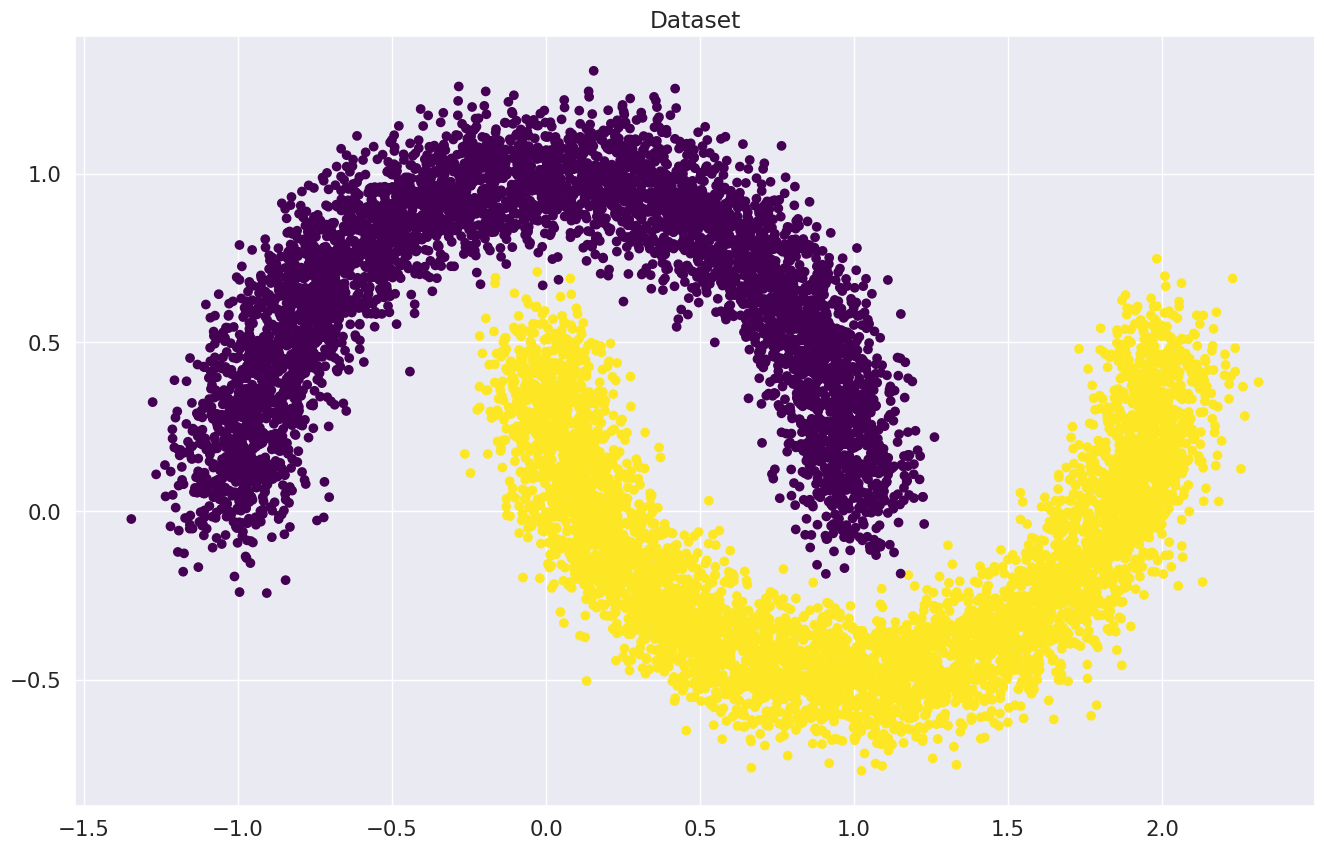

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.Tensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.Tensor(y_train) # YOUR CODE GOES HERE
X_val_t = torch.Tensor(X_val) # YOUR CODE GOES HERE
y_val_t = torch.Tensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = torch.randn(1) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights  # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias  # YOUR CODE GOES HERE
        return x

In [12]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ: 3 (2 веса и 1 баес)**

In [13]:
#YOUR CODE  
for parameter in linear_regression.parameters():
    print(parameter)

Parameter containing:
tensor([ 0.6018, -0.3560], requires_grad=True)


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [14]:
tol = 2e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)  # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.8125
Iteration: 200
Batch accuracy: 0.8359375
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.8828125
Iteration: 500
Batch accuracy: 0.921875

Iteration: 519.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 519 (или около того, зависит от начальных параметров)

### Визуализируем результаты

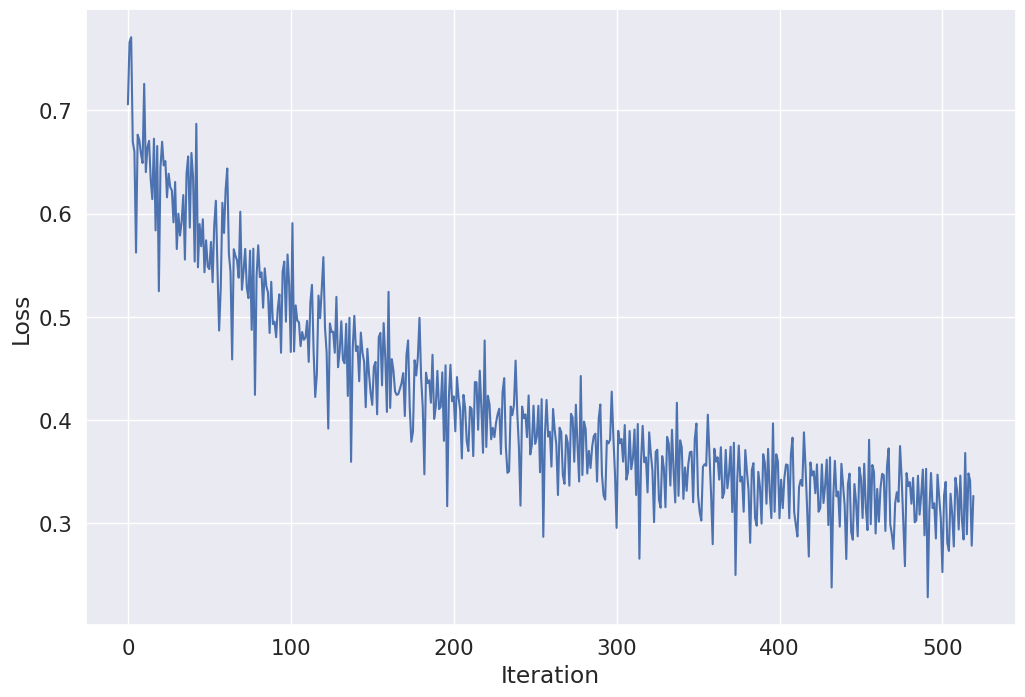

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

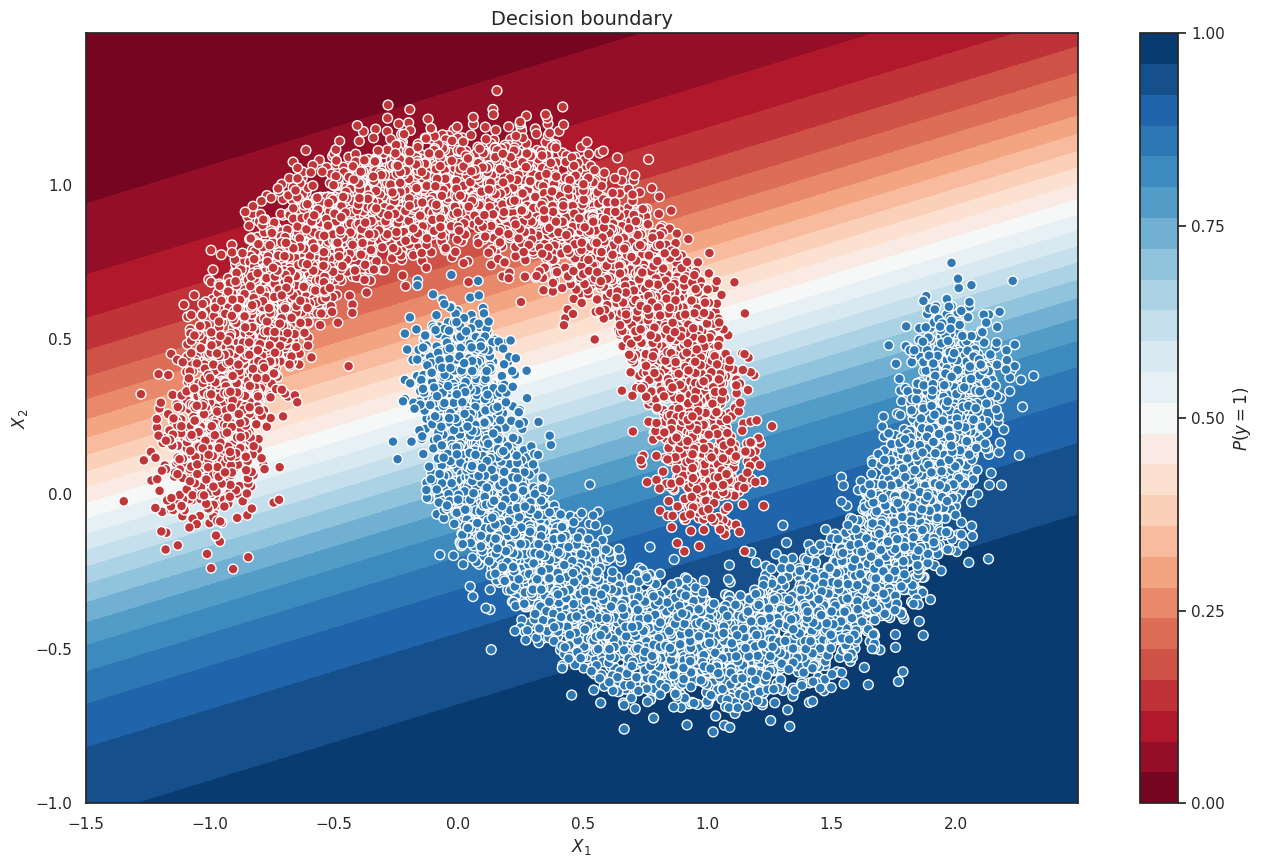

In [17]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch)) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [19]:
from sklearn.metrics import accuracy_score

predict_proba = predict(val_dataloader,linear_regression)
predictions = (predict_proba>0.5).astype(int)
print(accuracy_score(predictions,val_dataloader.dataset.tensors[1]))

# YOUR CODE. Compute total accuracy

0.878


In [20]:
accuracy_scores = np.zeros(100)
prob_thresholds = np.arange(0,1,0.01)

In [21]:
for i in range(0,len(prob_thresholds)):
    preds_tmp = (predict_proba>prob_thresholds[i]).astype(int)
    accuracy_scores[i] = accuracy_score(preds_tmp,val_dataloader.dataset.tensors[1])

In [22]:
print('best threshold =',accuracy_scores.argmax()/100)
print('best accuracy =',accuracy_scores.max())

best threshold = 0.64
best accuracy = 0.8924


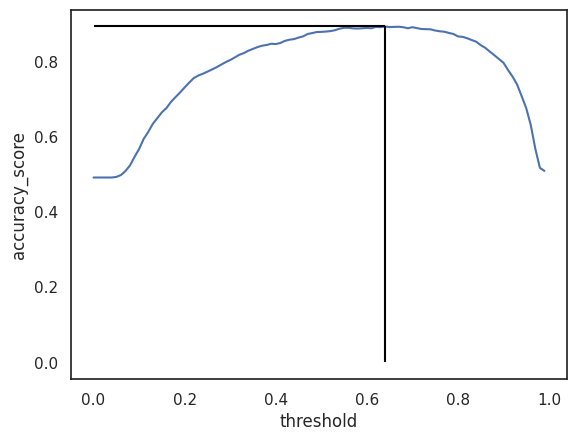

In [23]:
plt.plot(prob_thresholds,accuracy_scores)
plt.hlines(accuracy_scores.max(),0,accuracy_scores.argmax()/100,color='black')
plt.vlines(accuracy_scores.argmax()/100,0,accuracy_scores.max(),color='black')
plt.xlabel("threshold")
plt.ylabel("accuracy_score")
plt.show()

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.878 (при пороге 0.5) и лучший accuracy_score = 0.8924 при пороге 0.64

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [24]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=400,
                                               shuffle=True, num_workers=2)  # YOUR CODE GOES HERE
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=400,
                                               shuffle=False, num_workers=2) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [25]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [26]:
batch_size = train_dataloader.batch_size
print('batch_size =',batch_size)

flatten_size = train_dataloader.dataset.data.shape[1]*train_dataloader.dataset.data.shape[2]
print('flatten_size =', flatten_size)

batch_size = 400
flatten_size = 784


In [27]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flatten_size, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
    #YOUR CODE. Add layers to your sequential class
)

In [28]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [30]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():
                    outp = model(x_batch)
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch)  # YOUR CODE GOES HERE
            all = preds.shape[0]  # YOUR CODE GOES HERE
            epoch_correct += correct.sum().item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8530166666666666
Loader: valid. Accuracy: 0.9221
Epoch: 2
Loader: train. Accuracy: 0.92635
Loader: valid. Accuracy: 0.9406
Epoch: 3
Loader: train. Accuracy: 0.9462666666666667
Loader: valid. Accuracy: 0.9534
Epoch: 4
Loader: train. Accuracy: 0.95745
Loader: valid. Accuracy: 0.9608
Epoch: 5
Loader: train. Accuracy: 0.9656833333333333
Loader: valid. Accuracy: 0.9664
Epoch: 6
Loader: train. Accuracy: 0.9704333333333334
Loader: valid. Accuracy: 0.9701
Epoch: 7
Loader: train. Accuracy: 0.9745333333333334
Loader: valid. Accuracy: 0.9708
Epoch: 8
Loader: train. Accuracy: 0.9788666666666667
Loader: valid. Accuracy: 0.9719
Epoch: 9
Loader: train. Accuracy: 0.9801
Loader: valid. Accuracy: 0.9743
Epoch: 10
Loader: train. Accuracy: 0.9832666666666666
Loader: valid. Accuracy: 0.975


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [31]:
elu_accuracy = accuracy["valid"]

In [32]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flatten_size, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10))
    criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                     # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()  # <------------------ переводим модель в режим eval
                    with torch.no_grad():
                        outp = model(x_batch)
                     # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = (preds == y_batch)  # YOUR CODE GOES HERE
                all = preds.shape[0]  # YOUR CODE GOES HERE
                epoch_correct += correct.sum().item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [33]:
activation = Identical()
plain_accuracy = test_activation_function(activation)

Epoch: 1
Loader: train. Accuracy: 0.85395
Loader: valid. Accuracy: 0.9089
Epoch: 2
Loader: train. Accuracy: 0.9066
Loader: valid. Accuracy: 0.9129
Epoch: 3
Loader: train. Accuracy: 0.9103166666666667
Loader: valid. Accuracy: 0.9104
Epoch: 4
Loader: train. Accuracy: 0.9135666666666666
Loader: valid. Accuracy: 0.9138
Epoch: 5
Loader: train. Accuracy: 0.9154833333333333
Loader: valid. Accuracy: 0.9176
Epoch: 6
Loader: train. Accuracy: 0.9153666666666667
Loader: valid. Accuracy: 0.9185
Epoch: 7
Loader: train. Accuracy: 0.9169333333333334
Loader: valid. Accuracy: 0.9127
Epoch: 8
Loader: train. Accuracy: 0.9174833333333333
Loader: valid. Accuracy: 0.9185
Epoch: 9
Loader: train. Accuracy: 0.9172833333333333
Loader: valid. Accuracy: 0.916
Epoch: 10
Loader: train. Accuracy: 0.9192833333333333
Loader: valid. Accuracy: 0.9205


In [34]:
activation = nn.ReLU()
relu_accuracy = test_activation_function(activation)

Epoch: 1
Loader: train. Accuracy: 0.8327333333333333
Loader: valid. Accuracy: 0.9125
Epoch: 2
Loader: train. Accuracy: 0.9146666666666666
Loader: valid. Accuracy: 0.9281
Epoch: 3
Loader: train. Accuracy: 0.9349666666666666
Loader: valid. Accuracy: 0.9446
Epoch: 4
Loader: train. Accuracy: 0.9480166666666666
Loader: valid. Accuracy: 0.9525
Epoch: 5
Loader: train. Accuracy: 0.9562
Loader: valid. Accuracy: 0.9608
Epoch: 6
Loader: train. Accuracy: 0.9624666666666667
Loader: valid. Accuracy: 0.964
Epoch: 7
Loader: train. Accuracy: 0.9683333333333334
Loader: valid. Accuracy: 0.9664
Epoch: 8
Loader: train. Accuracy: 0.9694333333333334
Loader: valid. Accuracy: 0.9665
Epoch: 9
Loader: train. Accuracy: 0.9727833333333333
Loader: valid. Accuracy: 0.969
Epoch: 10
Loader: train. Accuracy: 0.9758
Loader: valid. Accuracy: 0.9705


In [35]:
activation = nn.LeakyReLU()
leaky_relu_accuracy = test_activation_function(activation) 

Epoch: 1
Loader: train. Accuracy: 0.8346833333333333
Loader: valid. Accuracy: 0.9093
Epoch: 2
Loader: train. Accuracy: 0.9188333333333333
Loader: valid. Accuracy: 0.936
Epoch: 3
Loader: train. Accuracy: 0.9393166666666667
Loader: valid. Accuracy: 0.9456
Epoch: 4
Loader: train. Accuracy: 0.9532
Loader: valid. Accuracy: 0.958
Epoch: 5
Loader: train. Accuracy: 0.9627
Loader: valid. Accuracy: 0.9637
Epoch: 6
Loader: train. Accuracy: 0.9671
Loader: valid. Accuracy: 0.958
Epoch: 7
Loader: train. Accuracy: 0.9714833333333334
Loader: valid. Accuracy: 0.9677
Epoch: 8
Loader: train. Accuracy: 0.9742
Loader: valid. Accuracy: 0.968
Epoch: 9
Loader: train. Accuracy: 0.9771
Loader: valid. Accuracy: 0.9664
Epoch: 10
Loader: train. Accuracy: 0.9799333333333333
Loader: valid. Accuracy: 0.9731


In [36]:
# plain_accuracy = test_activation_function(Identical)
# relu_accuracy = #YOUR CODE
# leaky_relu_accuracy = #YOUR CODE

In [37]:
print('elu_accuracy =', elu_accuracy[-1])
print('plain_accuracy =', plain_accuracy[-1])
print('relu_accuracy =', relu_accuracy[-1])
print('leaky_relu_accuracy =', leaky_relu_accuracy[-1])

elu_accuracy = 0.975
plain_accuracy = 0.9205
relu_accuracy = 0.9705
leaky_relu_accuracy = 0.9731


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

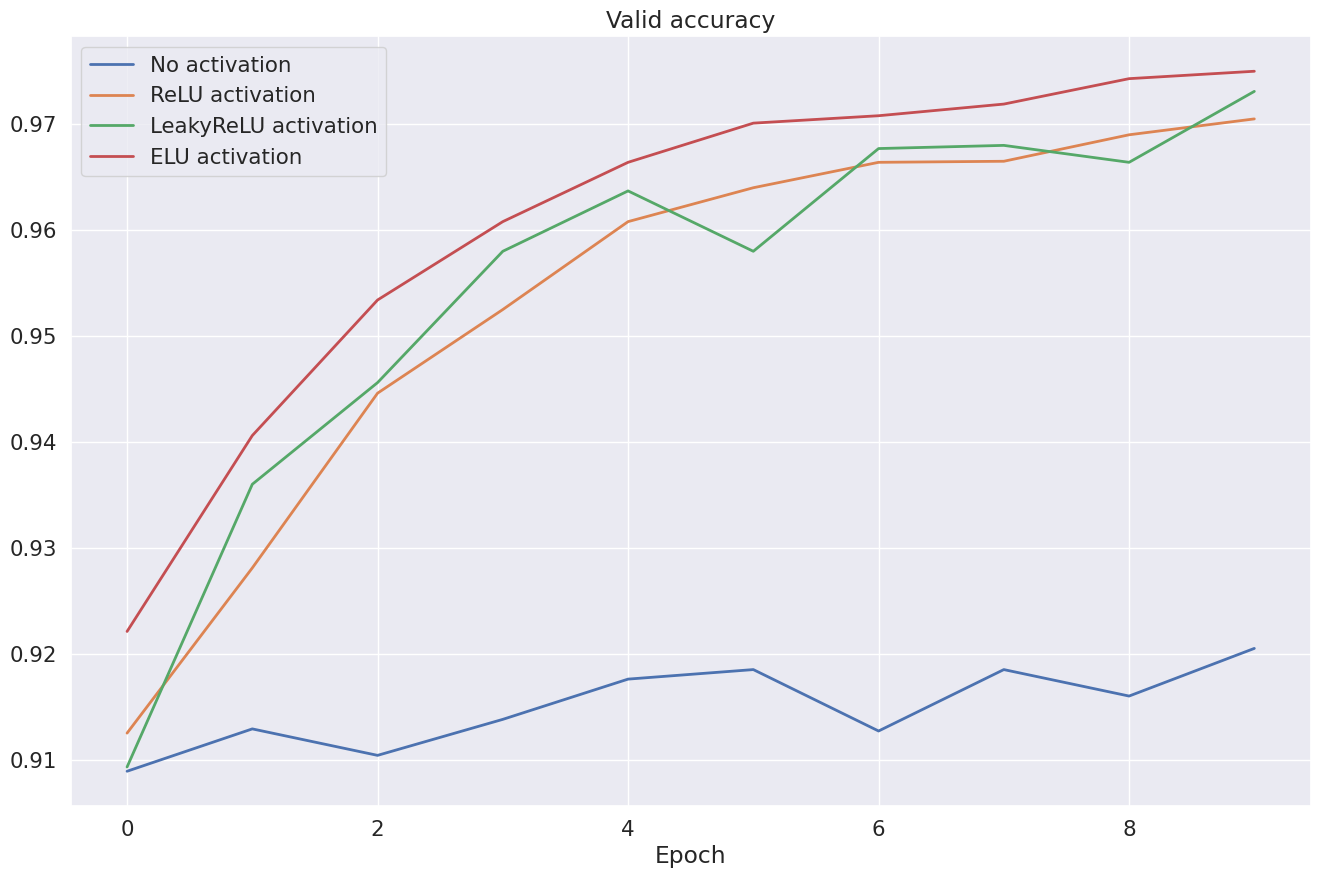

In [38]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

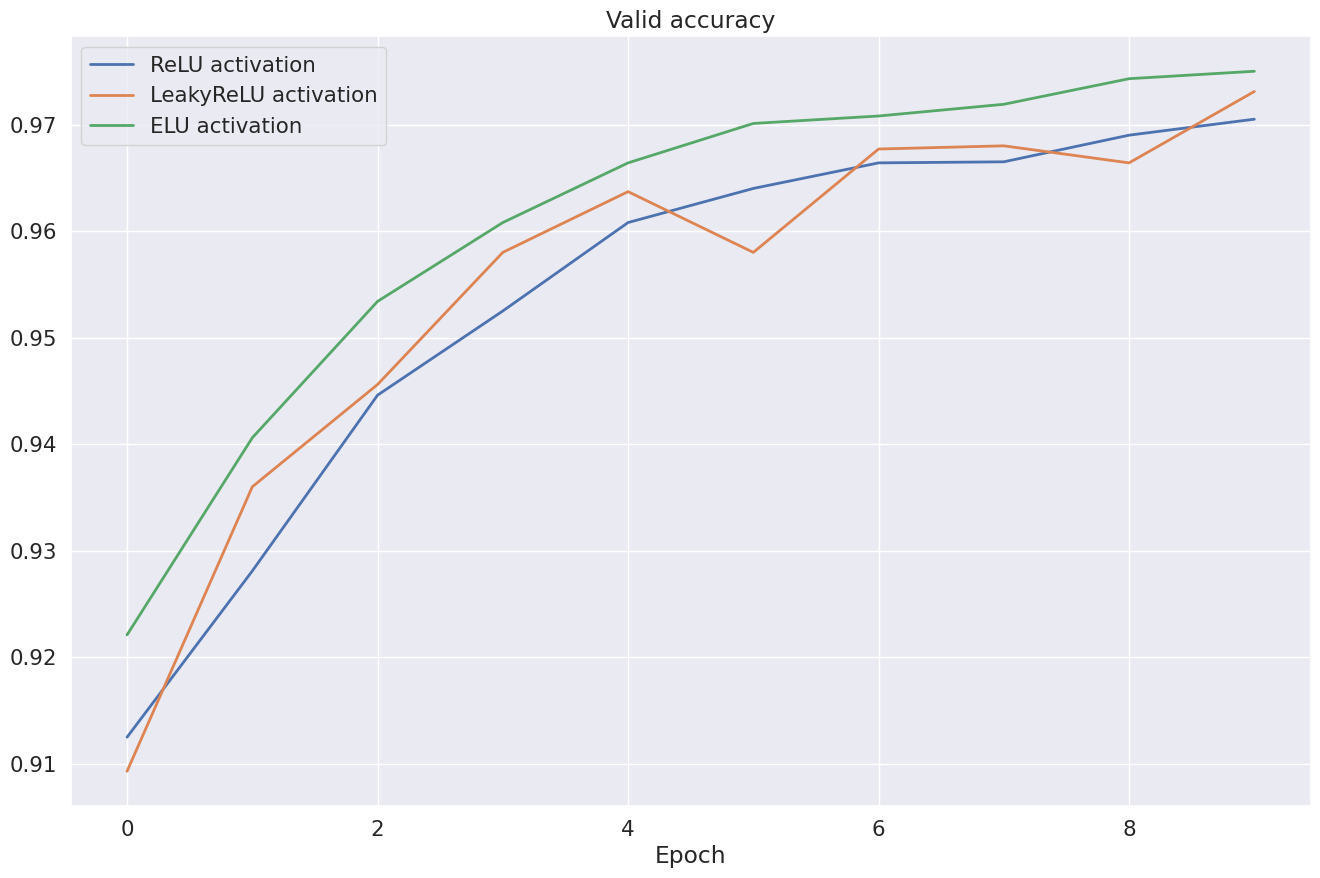

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [40]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-03-22 23:44:28--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.1s    

2024-03-22 23:44:29 (495 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



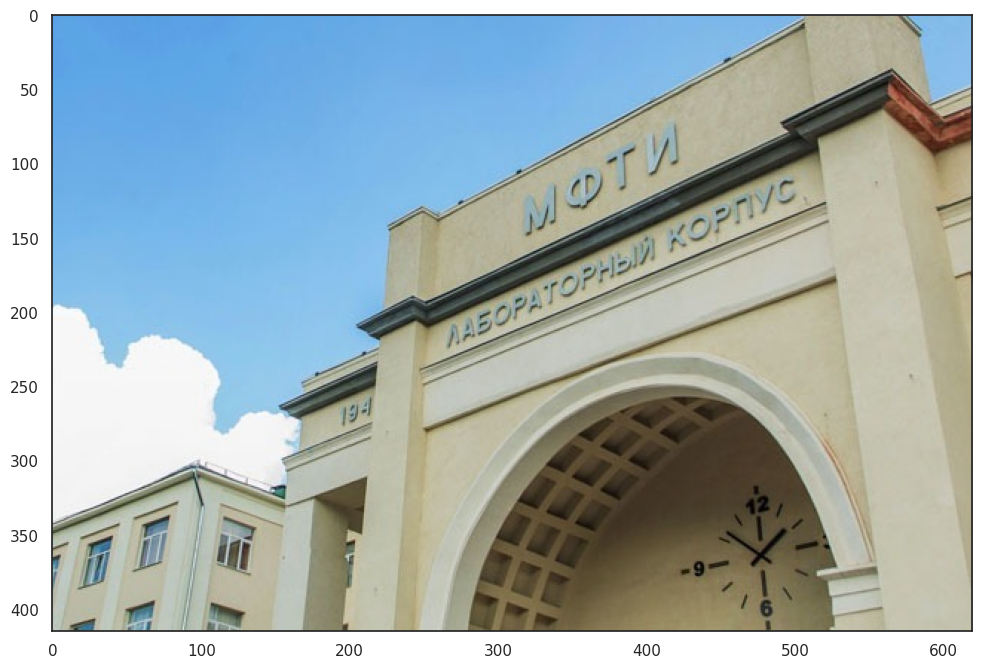

In [48]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [49]:
kernels = {'A':[[0, 0, 0],
                [0, 1, 0],
                [0, 0, 0]],
           'B':[[0, 1, 0],
                [0, -2, 0],
                [0, 1, 0]],
           'C':[[0, 0, 0],
                [1, -2, 1],
                [0, 0, 0]],
           'D':[[0, 1, 0],
                [1, -4, 1],
                [0, 1, 0]],
           'E':[[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]],
           'F':[[0.0625, 0.125, 0.0625],
                [0.125, 0.25, 0.125],
                [0.0625, 0.125, 0.0625]]}

In [50]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


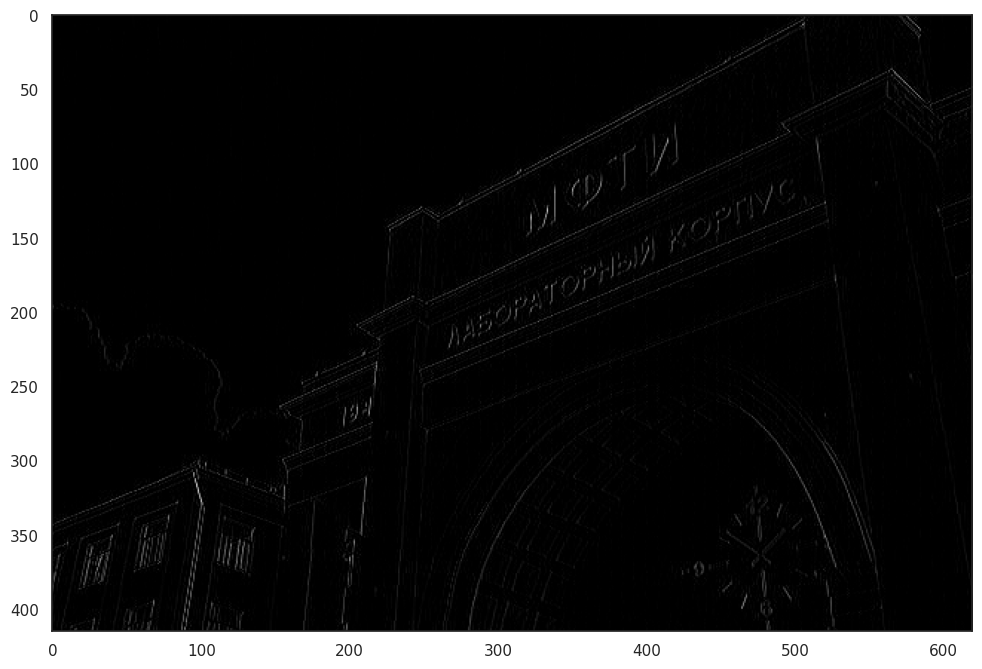

In [51]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


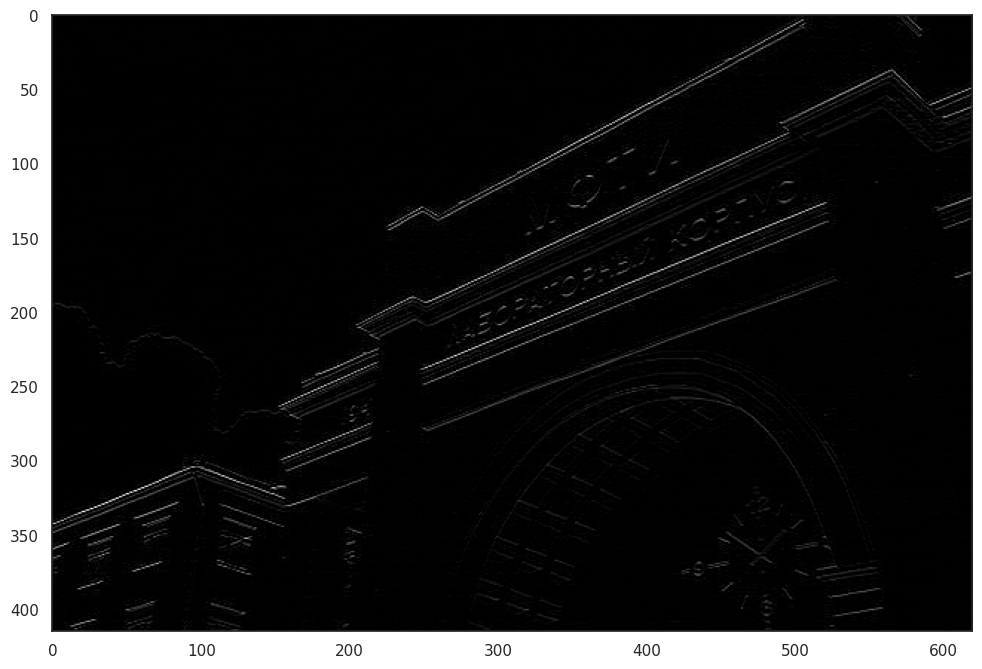

In [52]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor(kernels['B']).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие E

2) Увеличение резкости Д

3) Тождественное преобразование A

4) Выделение вертикальных границ B

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [53]:
import torch.nn.functional as F

In [54]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #YOUR CODE
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #YOUR CODE
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__.
        x = self.pool2(F.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [56]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch)  # YOUR CODE GOES HERE
            all = preds.shape[0]  # YOUR CODE GOES HERE
            epoch_correct += correct.sum().item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.83025
Loader: valid. Accuracy: 0.9519
Epoch: 2
Loader: train. Accuracy: 0.9573833333333334
Loader: valid. Accuracy: 0.9673
Epoch: 3
Loader: train. Accuracy: 0.9701333333333333
Loader: valid. Accuracy: 0.9769
Epoch: 4
Loader: train. Accuracy: 0.9762333333333333
Loader: valid. Accuracy: 0.9791
Epoch: 5
Loader: train. Accuracy: 0.98005
Loader: valid. Accuracy: 0.9825
Epoch: 6
Loader: train. Accuracy: 0.9827
Loader: valid. Accuracy: 0.9825
Epoch: 7
Loader: train. Accuracy: 0.9844666666666667
Loader: valid. Accuracy: 0.9837
Epoch: 8
Loader: train. Accuracy: 0.9862666666666666
Loader: valid. Accuracy: 0.983
Epoch: 9
Loader: train. Accuracy: 0.9877166666666667
Loader: valid. Accuracy: 0.9856
Epoch: 10
Loader: train. Accuracy: 0.9883333333333333
Loader: valid. Accuracy: 0.9855


In [57]:
lenet_accuracy = accuracy["valid"]

In [58]:
np.around(lenet_accuracy[9],2)

0.99

Сравним с предыдущем пунктом

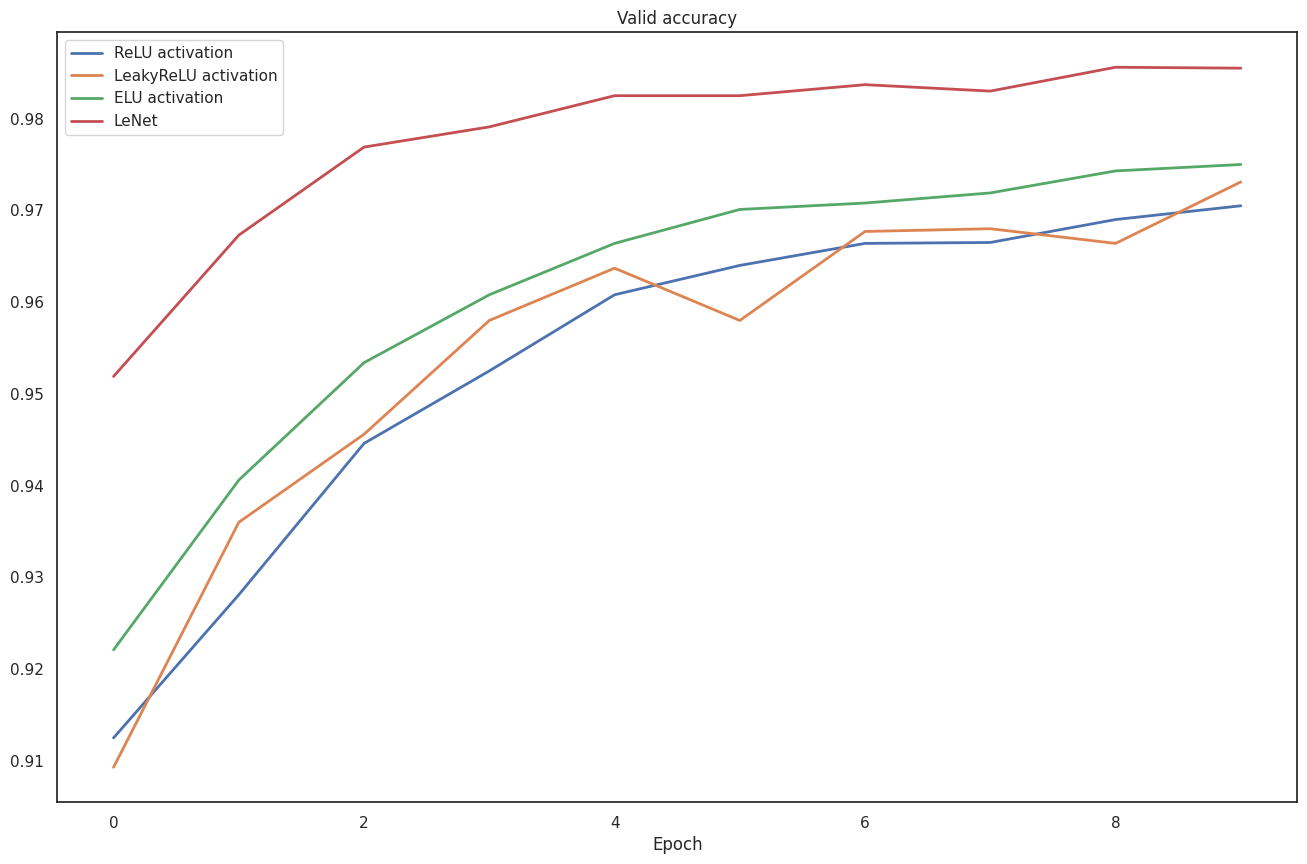

In [59]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99